# **🏆청경채 성장 예측 AI 경진대회**


https://dacon.io/competitions/official/235961/overview/description

수상작 : https://dacon.io/competitions/official/235961/codeshare/6582?page=1&dtype=recent


[목표]
환경 데이터로부터 청경채의 일별 잎 면적 증감률 예측하는 AI 알고리즘 개발


[설명]
각 청경채 케이스의 생육 기간 동안 1분 간격으로 수집된 환경 데이터로부터 일별 잎 면적 증감률을 예측

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 데이터 저장경로 및 LightGBM 설치
* 주최측에서 제공한 데이터인 open.zip을 아래 google drive 폴더에 업로드 해 놓고, google drive를 연결 시킨 상태에서 실행시키면, 파일이 복사되고 압축이 풀린다.
* CoLab의 디폴트 LightGBM 버전은 2.2.3이어서 그대로 실행하면 다른 결과를 산출하므로 반드시 3.3.2를 설치해야 한다.
* matplotlib에서 한글을 사용하기 위해 리눅스의 경우 한글폰트를 설치하고, 프로그램에서 폰트를 지정해야 한다.
* **LightGBM과 한글 폰트설치 후 런타임을 다시 시작**해야 한다.

In [ ]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/2022 청경채 성장 예측"/* .
!unzip -n -q open.zip

In [ ]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 29.3 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,200 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like progra

# Importing Packages
팩키지를 로딩하고, SEED와 상수를 선언한다.

In [ ]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import lightgbm as lgb

# Setting Random Seed
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#########################################################################################################
DATA_DIR = 'data/'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

TEST_OUTPUT = 'answer_example.csv'

#########################################################################################################
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

categoricals = []
FEATURES = ['시간','내부온도관측치','내부습도관측치','CO2관측치','EC관측치', '총추정광량']

In [ ]:
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Python: %s'%sys.version)

Numpy: 1.21.6
Pandas: 1.3.5
LightGBM: 3.3.2
Python: 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]


# 전처리용 클래스 선언
주요 처리내용은 다음과 같다.
1. 분단위 데이터를 60분씩 평균해서 24시간 데이터를 만든다.
2. 시간단위 데이터에서 일단위 합계 데이터를 추가한다.
3. 시간단위 데이터를 일단위 데이터로 바꾼다.
* test_input은 case별로 데이터를 사용하지만  train_input은 58개를 합쳐서 하나로 만들어서 사용한다.


In [ ]:
class LoadData(object):

    def __init__(self, DataType='train', TestNo=1):
        """
        DataType에 따라 폴더이름과 파일목록을 만든다.
        DataType: 'train', 'test' 둘 중 하나를 지정한다.
        TestNo: test case 번호를 지정한다. DataType이 'test'인 경우에만 사용된다.
        """
        self.DataType = DataType
        self.TestNo   = TestNo
        if (DataType == 'train'):
            self.x_dir = 'train_input'
            self.y_dir = 'train_target'
            self.x_list = sorted(glob(self.x_dir + '/*.csv'))
            self.y_list = sorted(glob(self.y_dir + '/*.csv'))
        else:
            self.x_dir = 'test_input'
            self.y_dir = 'test_target'
            self.x_list = sorted(glob(self.x_dir + f'/TEST_{TestNo:02d}.csv'))
            self.y_list = sorted(glob(self.y_dir + f'/TEST_{TestNo:02d}.csv'))
        return

    def read_data(self, x_file, y_file):
        """
        x_file과 y_file에 지정된 csv파일을 읽은 후, FEATURES에 정의된 피처만 선택한다.
        선택된 데이터는 24시간 단위로 변환된 후 하루에 하나의 샘플데이터가 되도록 만들어서 돌려준다.
        x_file: train_x 또는 test_x의 파일경로를 지정한다.
        y_file: train_y 또는 test_y의 파일경로를 지정한다.
        """
        x_df = pd.read_csv(x_file)[FEATURES].ffill().bfill()
        y_df = pd.read_csv(y_file)

        x_df['시간'] = pd.to_datetime(x_df['시간'])
        x_df.set_index('시간', inplace=True)                                    # 일자별로 resampling처리하기 위해 시간을 index로 만든다.

        if (self.DataType == 'train'):
            # train_y에서만 시간을 index로 설정하고, test_y에서는 submit할 때 사용하기 때문에 시간을 변환하거나 인덱스로 설정하지 않는다.
            y_df['시간'] = pd.to_datetime(y_df['시간'])
            y_df.set_index('시간', inplace=True)

        def one_day(df, cols):
            """
            24시간 단위의 시간당 평균자료와 하루의 합계자료를 합하여 25개 자료를 만든 후, 하나의 Series로 만들어서 돌려 준다.
            df: 하루 1440분의 1440건의 데이터를 담은 DataFrame이 들어 온다.
            cols: <24시간 + 1합계 = 25개 row>를 한개의 Series로 만들 때 사용할 각 항목이름 목록이 들어온다.
            """
            if (df.shape[0] < 1440):
                # 하루 1440분에 해당하는 자료가 모자르면 1440분에 해당하는 인덱스를 만들고 거기에 df를 연결시킨다.
                index = pd.date_range(start=df.index.date[0], periods=1440, freq='1T')
                df = pd.DataFrame(index=index).join(df)

            df = df.resample('1H').mean()                                       # 24시간 단위 resampling하여 시간당 평균을 구한다.
            df = df.append(df.sum(numeric_only=True), ignore_index=True)        # 하루의 합계를 추가한다.
            ar = np.array(df).flatten()                                         # 25개 row를 한개의 array로 만든다.
            data = pd.Series(ar, index=cols)
            return data

        HOURS = 25                                                              #  24시간 + 1합계 = 25개 row
        cols = [[f'{col}_{n}' for col in x_df.columns] for n in range(HOURS)]   # [[이름A_0, 이름B_0], ... [이름A_24, 이름B_24]]
        cols = np.array(cols).flatten()                                         # [이름A_0, 이름B_0, ... 이름A_24, 이름B_24]
        x_df = (x_df.groupby(x_df.index.date).apply(one_day, cols))             # 일자별로 데이터를 나누어 one_day(data, cols)를 호출한다.

        if (len(x_df) > len(y_df)):                                             # x데이터 수보다 y데이터 수가 적으면
            x_df = x_df.iloc[:len(y_df), :]                                     # x데이터 수를 y데이터 수만큼 줄인다.

        return x_df, y_df

    def read_train_raw(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        x_list, y_list = [], []
        for No in range(1, 59):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = pd.read_csv(x_file), pd.read_csv(y_file)

            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)

        return x_df, y_df

    def read_train(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        hdfile = DATA_DIR + f'train.h5'                                         # 'data/train.h5'
        if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
            x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
            y_df = pd.read_hdf(hdfile, 'y')
            return x_df, y_df

        x_list, y_list = [], []
        for No in range(1, 59):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = self.read_data(x_file, y_file)

            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')

        return x_df, y_df

    def read_test(self):
        """
        test데이터를 읽어서 X와 y를 돌려준다.
        test데이터의 01에서 06까지의 번호는 class생성시 지정된 TestNo를 사용한다.
        """
        hdfile = DATA_DIR + f'test_{self.TestNo}.h5'                            # 'data/test_n.h5'
        if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
            x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
            y_df = pd.read_hdf(hdfile, 'y')
            return x_df, y_df

        x_file = self.x_dir + f'/TEST_{self.TestNo:02d}.csv'
        y_file = self.y_dir + f'/TEST_{self.TestNo:02d}.csv'

        x_df, y_df = self.read_data(x_file, y_file)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        return x_df, y_df

    def read(self):
        """
        class생성시 지정된 DataType에 따라서, train데이터나 test데이터를 읽어서 돌려준다.
        """
        if (self.DataType == 'train'):
            return self.read_train()
        else:
            return self.read_test()

#########################################################################################################
def load_train():
    """
    LoadData('train') 클래스를 만들고 read()를 호출해서 train데이터를 읽어서 돌려준다.
    """
    train_x, train_y = LoadData('train').read()
    return train_x, train_y

def load_test(TestNo=1):
    """
    LoadData('test', TestNo) 클래스를 만들고 read()를 호출해서 test데이터를 읽어서 돌려준다.
    """
    test_x, test_y  = LoadData('test', TestNo).read()
    return test_x, test_y

def  load_spilit_train():
    """
    train데이터를 읽은 후, train_y에 log1p()를 적용시켜 데이터 평활화를 시킨다.
    train_x와 train_y의 20%로 tst_x, tst_y(테스트데이터)를 만들고, 나머지 80%의 20%로 다시 val_x, val_y(검증데이터)를 만든다.
    """
    train_x, train_y = load_train()

    train_y = np.log1p(train_y)

    train_x, tst_x, train_y, tst_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y

# 탐색적 자료분석(Exploratory Data Analysis) 및 변수선택
* LED와 난방기, 냉방기를 사용하는 것으로 보아서 식물공장이나 이와 비슷한 시설에서 재배되는 것으로 보인다. 따라서 외부 환경변수는 고려하지 않는다. 또한, 시설 관련 변수들은 내부환경을 조절하는 용도로서 시설가동의 결과가 내부환경변환로 나타난 것이다. 또, 시설 관련 변수는 데이터 건수가 너무 적으므로 사용하지 않는다.
* 내부 환경변수로는 **내부온도관측치**, **내부습도관측치**, **CO2관측치**, **EC관측치** 등이 있는데
데이터량이 일정수준 이상으로 나타나기 때문에 이 변수들을 사용하기로 한다.
* 광량 중에는 총추정광량의 데이터 갯수가 가장 많기 때문에 이것을 사용한다.

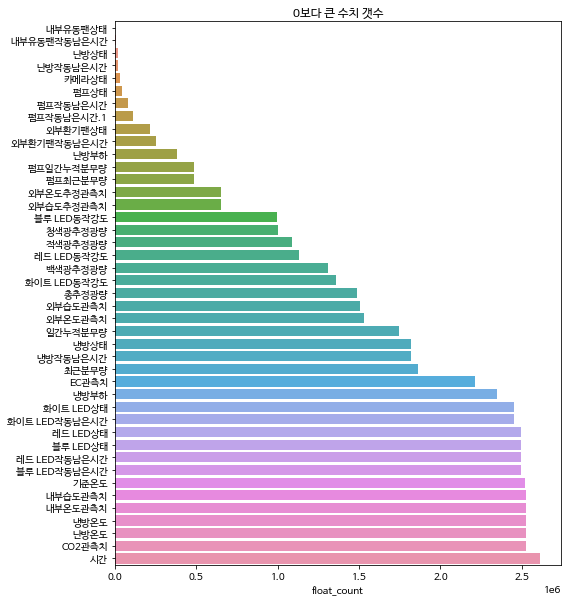

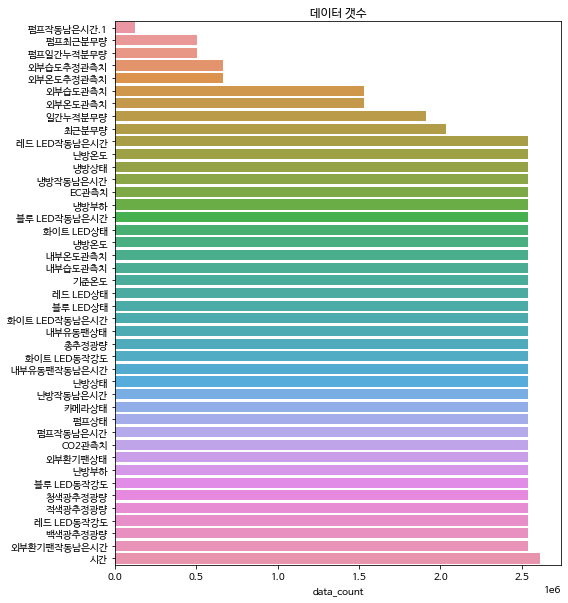

In [ ]:
train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_x.isnull()==False).sum()
null_count = (train_x.isnull()==True).sum()
float_count = (train_x.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

# 하루 1440분의 데이터 살펴 보기
선택된 변수의 하루 1440분의 데이터를 살펴 보면  온도, 습도, CO2는 시간의 흐름에 따라 변화가 있지만 EC와 광량에는 큰 변화가 없다. 따라서, 학습에 영향을 많이 줄 것은 온도, 습도, CO2임을 알 수 있다,

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

SAMPLE_NUM = 1440
COLS = FEATURES[1:]
fig = make_subplots(rows=len(COLS), cols=1, subplot_titles=COLS)
for row, col in enumerate(COLS, 1):
    fig.add_trace(go.Scatter(x=np.arange(SAMPLE_NUM), y=train_x[col].iloc[:SAMPLE_NUM], showlegend=False,
                        mode='lines+markers', name=col, marker=dict(color="orange")), row=row, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample data snippets")
fig.show()

# Target 변수 살펴보기
* Target 변수의 분포도를 보면 이상치(outlier) 들이 보임. 이상치를 제거하고 학습해 보았지만 특별한 향상이 없었다.
* Target 변수의 변화에는 특별한 흐름이 보이지 않았다.

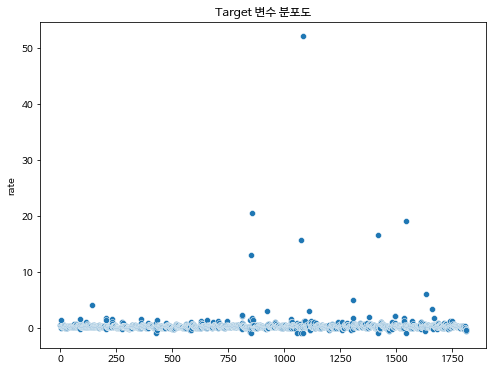

In [ ]:
train_y.reset_index(drop=True, inplace=True)
plt.figure(figsize=(8,6))
plt.title('Target 변수 분포도')
sns.scatterplot(x=train_y.index, y=train_y['rate'])                                     # 그래프를 그린다.
plt.show()

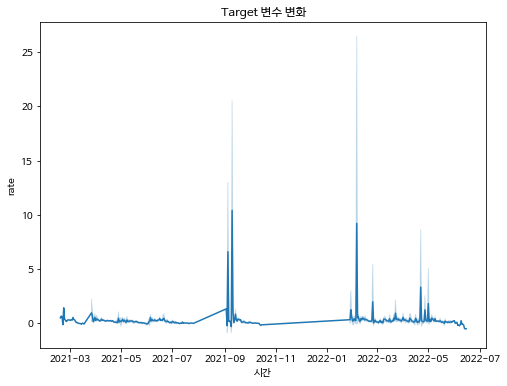

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Target 변수 변화')
sns.lineplot(x=pd.to_datetime(train_y['시간']), y=train_y['rate'])
plt.show()

# 모델구축
CoLab의 디폴트 LightGBM 버전은 2.2.3으로 다른 결과를 산출하므로 반드시 3.3.2를 설치하고 런타임을 다시 시작해야 한다.

In [ ]:
def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)] if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result,
                      categorical_feature=categoricals
                      )

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.

    pred_Y = model.predict(test_X)                                              # test_X의 label을 추론한다.

    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['prediction']) # 아니면 추론결과만 돌려준다.

    return model, evals_result, fi, cv_preds

In [ ]:
def tuning_max_bin():
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

    rmse_list = []
    max_bin_list = [511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(np.expm1(tst_y), np.expm1(cv_preds['prediction'])))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

# train, validation, test 학습결과
* 학습 결과 피처 중요도 상위 10개 중에서 CO2, 내부습도, 내부온도 순으로 많이 사용된 것으로 나타난다.
* Actual과 Prediction에서 비례의 상관관계가 나타나기 때문에 정상적으로 학습이 된 것으로 보인다.
* Iteration이 100일 때, fair loss가 정상적으로 상승곡선을 나타내고 있다.

max_bin: 511. RMSE:  1.351
max_bin:2047. RMSE:  1.356
max_bin:4095. RMSE:  1.356
Best max_bin: 511


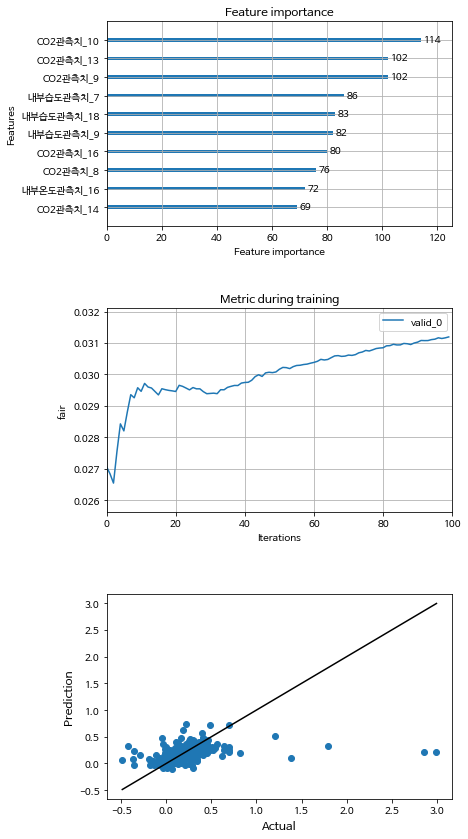

Features Importance Split & Gain...
        feature  split      gain
91   내부습도관측치_18     83  9.962730
88     EC관측치_17     25  5.354109
46    내부습도관측치_9     82  4.069132
52    CO2관측치_10    114  3.821110
36    내부습도관측치_7     86  3.335549
38      EC관측치_7     28  3.228669
47     CO2관측치_9    102  2.437927
66   내부습도관측치_13     53  2.186648
61   내부습도관측치_12     56  2.030921
42     CO2관측치_8     76  1.954596
26    내부습도관측치_5     50  1.616948
72    CO2관측치_14     69  1.594963
76   내부습도관측치_15     33  1.508253
45    내부온도관측치_9     62  1.507297
51   내부습도관측치_10     62  1.453084
67    CO2관측치_13    102  1.400300
80   내부온도관측치_16     72  1.317865
65   내부온도관측치_13     51  1.260155
49      총추정광량_9     45  1.153031
71   내부습도관측치_14     38  1.141716
82    CO2관측치_16     80  1.095240
32     CO2관측치_6     65  1.047303
56   내부습도관측치_11     28  1.045304
106  내부습도관측치_21     44  1.040222
35    내부온도관측치_7     38  0.951250
100  내부온도관측치_20     53  0.893564
101  내부습도관측치_20     47  0.860804
92    CO2관측치_18     58  0.859419
25    내

In [ ]:
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(),
                    'split':model.feature_importance('split'),
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


max_bin = tuning_max_bin()
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

params = {'max_bin':max_bin, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [ ]:
max_bin = tuning_max_bin()
train_x, train_y = load_train()

RepNo = 6                                                                       # 품목 갯수
for rep in range(1, RepNo+1):
    print(f"Learning and Predicting for RepNo: {rep}")
    test_x, test_y = load_test(TestNo=rep)

    if (rep == 1):                                                              # 학습은 첫번째에만 하도록 한다.
        model, _, _, cv_preds = run_lgb({'max_bin':max_bin}, train_x, train_y, None, None, test_x, None)
        pred_Y = cv_preds.values
    else:
        pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

    test_y['rate'] = pred_Y
    test_y.to_csv(RESULTS_DIR + f'TEST_{rep:02d}.csv')

import zipfile
os.chdir(RESULTS_DIR)
submission = zipfile.ZipFile("submission.zip", 'w')
for rep in range(1, RepNo+1):
    path = f'TEST_{rep:02d}.csv'
    submission.write(path)
submission.close()
print(f'Saved {RESULTS_DIR}submission.zip')
os.chdir("..")

max_bin: 511. RMSE:  1.351
max_bin:2047. RMSE:  1.356
max_bin:4095. RMSE:  1.356
Best max_bin: 511
Learning and Predicting for RepNo: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002817 seconds.
You can set `force_col_wise=true` to remove the overhead.
Learning and Predicting for RepNo: 2
Learning and Predicting for RepNo: 3
Learning and Predicting for RepNo: 4
Learning and Predicting for RepNo: 5
Learning and Predicting for RepNo: 6
Saved results/submission.zip


# 결과 및 결언
아래와 같은 다양한 시도를 해 본 결과, 작물의 생육에 직접적인 영향을 주는 변수만을 선택하고, 데이터를 60분 단위로 만든 후, LightGBM을 사용해서 추론 하는 것이 가장 성적이 좋았다.
* 24시간 단위 데이터 다음에 오는 25번째 데이터로 분산, 최고, 최저, 평균, 합계 등을 시도해 보았지만 합계가 가장 성적이 좋았다.
* 30분단위, 15분단위, 5분단위로 시도해 보았지만 60분 단위에서 가장 성적이 좋았다.
* 총추정광량 대신에 다른 광 관련 변수를 사용해 보았지만 성적이 좋지 못했다.
* Keras로 LSTM을 구성해 보았지만 LightGBM의 성적을 항상 넘지 못했다.
* Keras의 LSTM 추론 결과를 LightGBM에 연동해 보았지만 Keras의 성적 이상이 나오지 않았다.
* LightGBM에 Holt-Winters기법을 추가해 보았지만 LightGBM 단독의 성적을 넘어서지 못했다.

# 추가 제언
* LightGBM의 하이퍼파라미터에서 num_boost_round를 디폴트값인 100을 사용하였는데, 과적합 되지 않는 한도 내에서 이 값을 올리면서 예측율 향상을 시도해 볼만 하다.
* max_bin을 [511, 2047, 4095] 중에서 선택하였으나 작은 숫자를 포함한 다양한 숫자에서 시도해 볼 필요가 있어 보인다.
* LightGBM의 하이퍼파라미터 튜닝을 위해 교차검증을 고려해 볼만 하다.
* submit용으로 학습을 할 때 y(label)에 대해 로그/지수 평활화를 시도해 볼 필요가 있어 보인다.